# MNIST: мотивация использовать нейросети

In [1]:
import tensorflow as tf  # пока что используем этот пакет только для скачки данных :)
import numpy as np
import sklearn
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [0]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

In [3]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


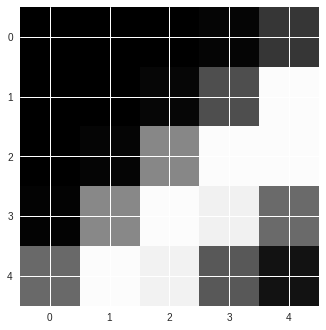

Пример картинки:


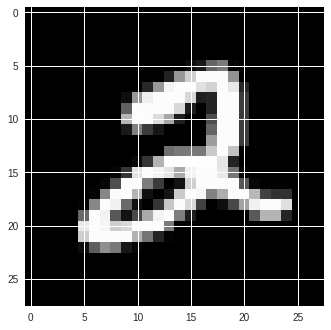

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [4]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

# Линейная модель

Линейная модель не умеет работать с двумерным входом, поэтому предлагается превратить картинку 28x28 в вектор длины 28*28=784, выписав ее построчно!

<img src="https://camo.githubusercontent.com/f663cd4f29335972950dded4d422c07aeee8af55/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313630302f312a34473067737539327250684e2d636f397076315035414032782e706e67" width="400">


In [9]:
x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val_flat.shape)

(60000, 784)
(10000, 784)


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_val_flat = scaler.transform(x_val_flat)

In [18]:
# кусочек фичей
x_train_flat[0, ::20]

array([ 0.        ,  0.        , -0.03059266, -0.00852241, -0.01408835,
       -0.2625969 , -0.16124756,  0.        ,  1.71565971,  0.74933951,
       -0.11300485, -0.19700703,  1.12192712,  0.27021375, -0.00577281,
       -0.70132425,  1.64634567, -0.1273685 , -0.15382451, -0.19833719,
       -0.70732309, -0.00477028, -0.60978718, -0.9194134 , -0.17786005,
       -0.16833376,  0.65022085, -0.63188648,  0.        , -0.48806277,
        1.17394853, -0.14774138, -0.07003976, -0.61257571,  3.52099754,
        0.        , -0.09396514, -0.1826269 , -0.00579016,  0.        ])

In [19]:
%%time
# обучаем линейную модель, обучается градиентными методами оптимизации
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class="multinomial", solver="lbfgs")
clf.fit(x_train_flat, y_train)

CPU times: user 1min 16s, sys: 4.94 s, total: 1min 21s
Wall time: 41.2 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [21]:
# не так плохо работает!
from sklearn.metrics import accuracy_score
accuracy_score(y_val, clf.predict(x_val_flat))

0.9246

# Градиентный бустинг

<img src="https://www.researchgate.net/profile/Maria_Peraita-Adrados/publication/326379229/figure/fig5/AS:647978477948928@1531501516288/A-simple-example-of-visualizing-gradient-boosting_W640.jpg" width="300">

Над деревьями делают бустинг и это алгоритм №1 на Kaggle! Проверим в нашей задаче!

In [32]:
%%time
# очень долго работает (потому что алгоритм переборный)!
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(learning_rate=0.3, n_estimators=10, verbose=1, subsample=0.5)
clf.fit(x_train_flat, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       39985.6554       28714.1686            3.32m
         2       31412.0718        8641.5732            2.95m
         3       25408.3052        5680.0781            2.64m
         4       21762.9822        3544.6881            2.28m
         5       19197.6986        2600.7659            1.89m
         6       17329.1094        1901.8676            1.51m
         7       15265.1690        1804.2433            1.13m
         8       13979.1283        1277.8810           45.27s
         9       13082.2559         908.0964           22.60s
        10       12156.0697         921.5624            0.00s
CPU times: user 3min 48s, sys: 75 ms, total: 3min 48s
Wall time: 3min 48s


In [33]:
# качество так себе, а если картинка будет 300x300 это будет еще и вечность работать!
accuracy_score(y_val, clf.predict(x_val_flat))

0.8909

# Нейросети

Соберем сложную функцию как комбинацию простых линейных моделей (например, логистических регрессий):

<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="300">

Для оптимизации всех параметров нам не нужен перебор, мы можем честно посчитать производную потерь по каждому параметру и чуточку их подвинуть! Это работает очень быстро!


In [34]:
%%time
from sklearn.neural_network import MLPClassifier  # многослойный персептрон (просто много полносвязных слоев)
clf = MLPClassifier(max_iter=10, random_state=0)
clf.fit(x_train_flat, y_train)

CPU times: user 25.9 s, sys: 8.32 s, total: 34.2 s
Wall time: 17.4 s


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [35]:
# качество выше линейной модели, скорость на высоте!
# будем копать в сторону нейросетей!
accuracy_score(y_val, clf.predict(x_val_flat))

0.9742